### Eye Pattern Recognition

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

class EyePatternPredictor:
    def __init__(self):
        # Define patterns with their normal distributions (mean, std)
        self.patterns = {
            'spotted': norm(15, 5),   # Teenagers - scattered, non-linear exploration pattern
            'z_pattern': norm(25, 7),  # Young adults - quick zigzag assessment pattern
            'f_pattern': norm(40, 12), # Middle-aged - horizontal top + vertical left scanning
            'layered': norm(70, 15)    # Elderly - methodical, layer-by-layer reading
        }
        
        self.pattern_names = {
            'spotted': 'Spotted Pattern',
            'z_pattern': 'Z-Pattern',
            'f_pattern': 'F-Pattern',
            'layered': 'Layered Pattern'
        }

    def predict(self, age):
        """Predicts single most likely eye scanning pattern for given age."""
        if age < 0 or age > 120:
            return "Invalid age input"
        
        # small interval (epsilon) around the point
        epsilon = 0.1
        
        probabilities = {
            pattern: dist.cdf(age + epsilon/2) - dist.cdf(age - epsilon/2)
            for pattern, dist in self.patterns.items()
        }
        
        # Normalize probabilities to sum to 1
        total = sum(probabilities.values())
        normalized_probs = {
            k: v/total for k, v in probabilities.items()
        }
        
        # Select pattern with highest probability
        selected_pattern = max(normalized_probs, key=normalized_probs.get)
        return self.pattern_names[selected_pattern]

    def explain_prediction(self, age):
        """Shows detailed probability breakdown for given age."""
        if age < 0 or age > 120:
            return "Invalid age input"
        
        # Get raw probabilities
        raw_probs = {
            pattern: dist.pdf(age) 
            for pattern, dist in self.patterns.items()
        }
        
        # Normalize probabilities
        total = sum(raw_probs.values())
        normalized = {k: v/total for k, v in raw_probs.items()}
        
        print(f"\nProbability breakdown for age {age}:")
        print("\nRaw probabilities (from PDF):")
        for pattern, prob in raw_probs.items():
            print(f"{self.pattern_names[pattern]}: {prob:.4f}")
            
        print("\nNormalized probabilities:")
        for pattern, prob in normalized.items():
            print(f"{self.pattern_names[pattern]}: {prob:.2%}")
            
        winner = max(normalized, key=normalized.get)
        print(f"\nPredicted pattern: {self.pattern_names[winner]}")

    def visualize_distributions(self):
        """Visualizes the probability distributions for all patterns."""
        ages = np.linspace(0, 100, 1000)
        
        plt.figure(figsize=(12, 6))
        
        # Plot each distribution
        for pattern, dist in self.patterns.items():
            probabilities = dist.pdf(ages)
            plt.plot(ages, probabilities, label=self.pattern_names[pattern])
        
        # Plot styling
        plt.title('Eye Scanning Pattern Probabilities by Age')
        plt.xlabel('Age')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.grid(True)
        plt.show()


# Create predictor
predictor = EyePatternPredictor()

# Show distributions
predictor.visualize_distributions()

# Test some predictions
test_ages = [15, 22, 35, 65, 75]
print("\nQuick predictions:")
for age in test_ages:
    pattern = predictor.predict(age)
    print(f"Age {age}: {pattern}")

In [ ]:
# Detailed explanation for one age
predictor.explain_prediction(35)

### P(knowledge)

[Use either Molmo or Florence-2 as VLM](https://www.reddit.com/r/LocalLLaMA/comments/1g9tqoh/any_way_to_localize_objects_in_image_with_vlm/?rdt=47240)

#### Florence-2

In [1]:
import requests
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM 

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large-ft", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large-ft", trust_remote_code=True)

def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

url = "ui_cropped.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open(url)

/home/yaseen/featurely/virtual/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yaseen/featurely/virtual/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by

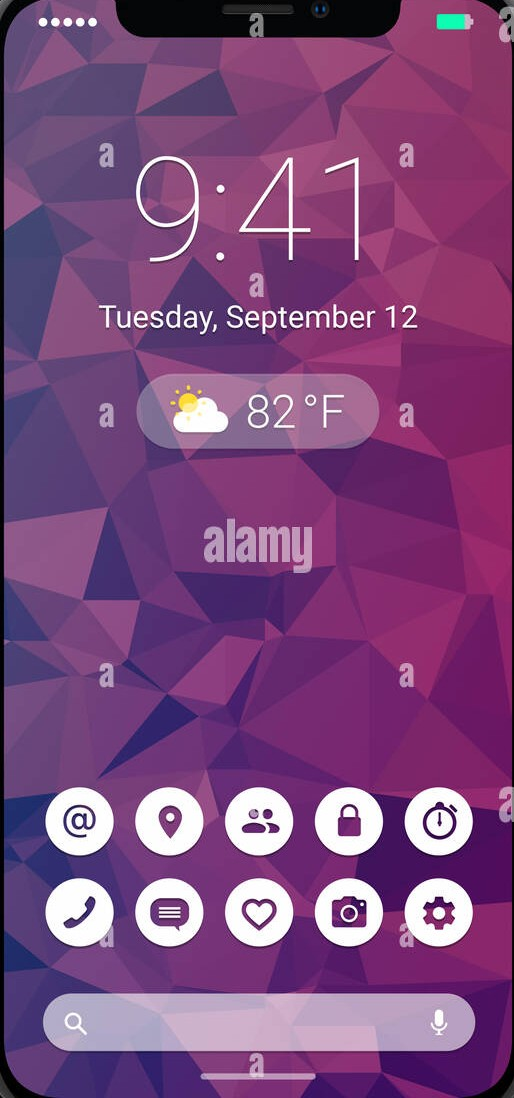

In [2]:
from IPython.display import display
from PIL import Image

display(image)

In [3]:
task_prompt = '<CAPTION>'
run_example(task_prompt)

{'<CAPTION>': 'a phone screen showing the time of 9:41 on tuesday, september 12th - stock image'}

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bbox(image, data):
    # Create a figure and axes
    fig, ax = plt.subplots()
    
    # Display the image
    ax.imshow(image)
    
    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    
    # Remove the axis ticks and labels
    ax.axis('off')
    
    # Display the plot inline
    plt.show()

In [5]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="google maps app")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[3.3410000801086426, 0.5490000247955322, 513.22900390625, 1096.35302734375]], 'labels': ['google maps app']}}


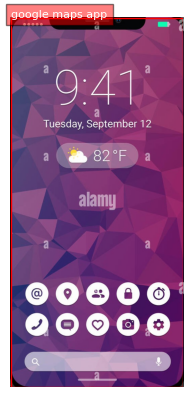

In [6]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

#### Molmo

In [7]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-7B-Instruct",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# default processor
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

KeyboardInterrupt: 

#### SmolLM + UI-tars

In [ ]:
# pip install transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM-135M-Instruct"

device = "cuda" # for GPU usage or "cpu" for CPU usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# for multiple GPUs install accelerate and do `model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map="auto")`
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

messages = [{"role": "user", "content": """Answer in one sentence: 

Imagine you are looking at an android screen. 
The task is to find the battery percentage.
You are a technically savvy user of android. You have good intuition about android screens and their layouts. And you prefer shortcuts to accomplish tasks.

Where(which part of the screen) would your eyes look first, to accomplish the task ?"""}]
input_text=tokenizer.apply_chat_template(messages, tokenize=False)
print(input_text)
inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
outputs = model.generate(inputs, max_new_tokens=70, temperature=0.2, top_p=0.9, do_sample=True)
print(tokenizer.decode(outputs[0]))
